In [1]:
# imports
import sys
sys.path.insert(0, '..')

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import table 
import scipy.stats as stats
import seaborn as sn
from statsmodels.stats.power import TTestIndPower

from src import load_eeg, load_subjs, plot_eeg

In [2]:
# set ploting parameters
plt.rcParams['font.serif'] = 'Ubuntu'
plt.rcParams['font.monospace'] = 'Ubuntu Mono'
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['axes.titlesize'] = 10
plt.rcParams['xtick.labelsize'] = 8
plt.rcParams['ytick.labelsize'] = 8
plt.rcParams['legend.fontsize'] = 10
plt.rcParams['figure.titlesize'] = 12

In [3]:
# load data
control_filepath = '../data/control_all.csv'
epochs_filepath = '../data/epochs_all.csv'

control = pd.read_csv(control_filepath)
epochs = pd.read_csv(epochs_filepath)

In [4]:
# remove old index
control.drop('Unnamed: 0', inplace=True, axis=1)
epochs.drop('Unnamed: 0', inplace=True, axis=1)

In [5]:
# establish alpha via Bonferroni correction
a = 0.05
n_test = len(control.columns)
a_b = a / n_test

In [6]:
# perform t test
t, p = stats.ttest_ind(control, epochs, equal_var=False)

In [7]:
# build dataframe from t test
df = pd.DataFrame([t, p], columns=control.columns, index=['t', 'p'])
df = df.T

# add signicant result columns
df['sig'] = df['p'] < a_b  # note: most p values are too small to be stowed in memory

In [8]:
# calculate power
powers = []

for col in control.columns:
    # extablish arguments
    effect_size = (control[col].mean() - epochs[col].mean()) / control[col].std()
    nobs1 = len(control)
    alpha = 0.05
    ratio = len(control[col]) / len(epochs[col])
    
    # determine power
    analysis = TTestIndPower()
    result = analysis.power(effect_size=effect_size, nobs1=nobs1, alpha=alpha, ratio=ratio)
    powers.append(result)

In [9]:
# add power to dataframe
df['power'] = powers

In [10]:
# assess effect size
control_mean = control.mean()
epochs_mean = epochs.mean()

abs_effect_size = control_mean - epochs_mean
relev_effect_size = abs_effect_size / control_mean

In [11]:
# add effect sizes to dataframe
df['abs_effect_size'] = abs_effect_size
df['relev_effect_size'] = relev_effect_size

# save dataframe as html
df.to_html('../stats.html')

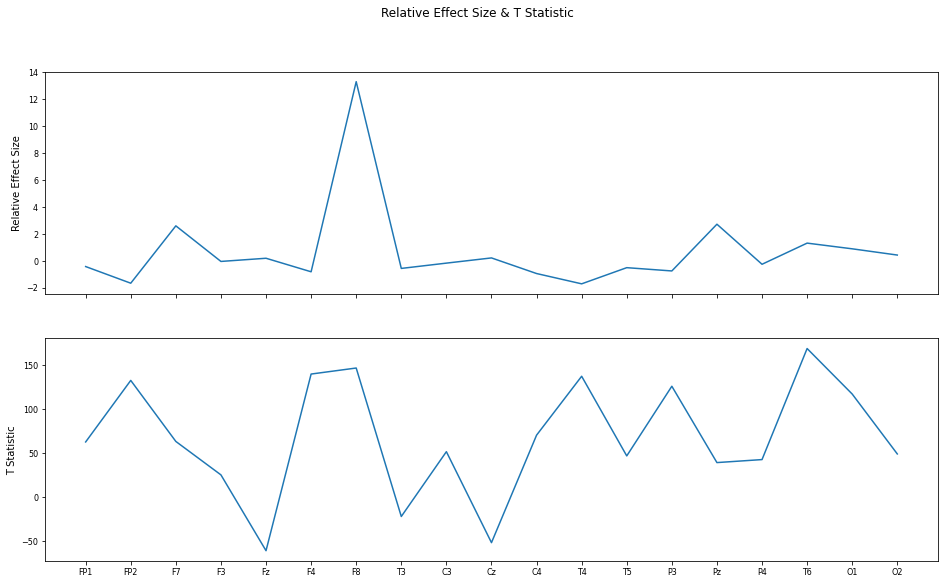

In [17]:
fig, bx = plt.subplots(2, sharex='all', figsize=(16, 9))

bx[0].plot(df['relev_effect_size'])
bx[1].plot(df['t'])

bx[0].set_ylabel('Relative Effect Size')
bx[1].set_ylabel('T Statistic')

fig.suptitle('Relative Effect Size & T Statistic')
plt.savefig('../img/relev_effect_size_t_stat.jpg')